# Working with FB Prophet
##  [Holliday Effects](https://facebookincubator.github.io/prophet/docs/holiday_effects.html) example from FB page  

Lok at time series of daily page views for the Wikipedia page for Peyton Manning. The csv is available [here](https://github.com/facebookincubator/prophet/blob/master/examples/example_wp_peyton_manning.csv)

In [1]:
#wp_R_dataset_url = 'https://github.com/facebookincubator/prophet/blob/master/examples/example_wp_R.csv'
wp_peyton_manning_filename = '../datasets/example_wp_peyton_manning.csv'

In [2]:
%matplotlib inline
from fbprophet import Prophet
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


### import the data and transform to log-scale

In [3]:
df = pd.read_csv(wp_peyton_manning_filename)
# transform to log scale
df['y']=np.log(df['y'])
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=366)


### Modeling Holidays

<hr>

If you have holidays that you’d like to model, you must create a dataframe for them. It has two columns (`holiday` and `ds`) and a row for each occurrence of the holiday. It must include all occurrences of the holiday, both in the past (back as far as the historical data go) and in the future (out as far as the forecast is being made). If they won’t repeat in the future, Prophet will model them and then not include them in the forecast.


You can also include columns `lower_window` and `upper_window` which extend the holiday out to `[lower_window, upper_window]` days around the date. For instance, if you wanted to included Christmas Eve in addition to Christmas you’d include `lower_window=-1,upper_window=0`. If you wanted to use Black Friday in addition to Thanksgiving, you’d include `lower_window=0,upper_window=1`.

Here we create a dataframe that includes the dates of all of Peyton Manning’s playoff appearances:

In [4]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))
holidays.head()

,ds,holiday,lower_window,upper_window
0,2008-01-13,playoff,0,1
1,2009-01-03,playoff,0,1
2,2010-01-16,playoff,0,1
3,2010-01-24,playoff,0,1
4,2010-02-07,playoff,0,1


Above we have include the superbowl days as both playoff games and superbowl games. This means that the superbowl effect will be an additional additive bonus on top of the playoff effect.

Once the table is created, holiday effects are included in the forecast by passing them in with the `holidays` argument. Here we do it with the Peyton Manning data from the Quickstart:

In [5]:
m = Prophet(holidays=holidays)
forecast = m.fit(df).predict(future)

<hr>
The holiday effect can be seen in the `forecast` dataframe:

In [6]:
forecast[(forecast['playoff']+forecast['superbowl']).abs() > 0][['ds','playoff','superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.224671,1.198000
2191,2014-02-03,1.901035,1.474798
2532,2015-01-11,1.224671,0.000000
2533,2015-01-12,1.901035,0.000000
2901,2016-01-17,1.224671,0.000000
2902,2016-01-18,1.901035,0.000000
2908,2016-01-24,1.224671,0.000000
2909,2016-01-25,1.901035,0.000000
2922,2016-02-07,1.224671,1.198000
2923,2016-02-08,1.901035,1.474798


The holiday effects will also show up in the components plot, where we see that there is a spike on the days around playoff appearances, with an especially large spike for the superbowl:

Whereas decreasing it will make the trend _less_ flexible

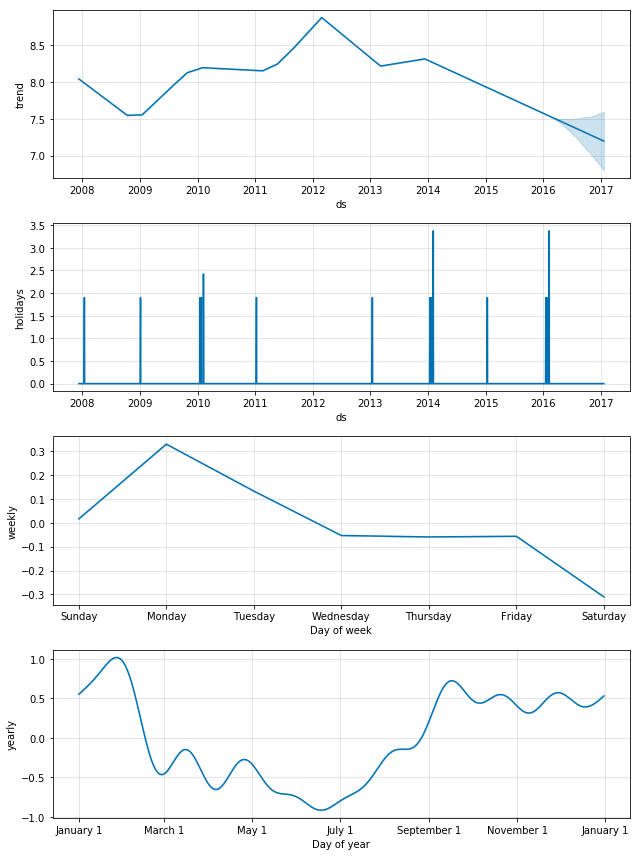

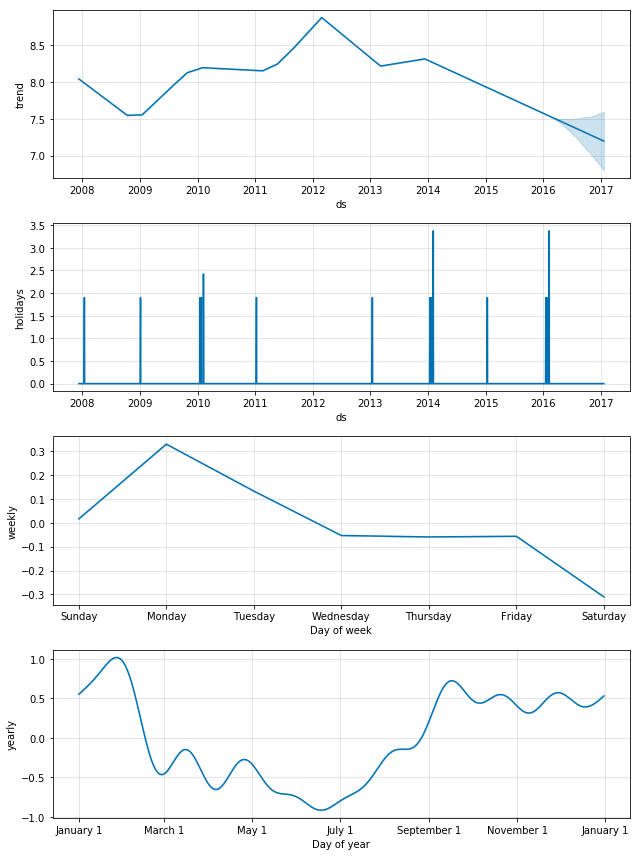

In [7]:
m.plot_components(forecast)

### Prior scale for holidays and seasonality

<hr>
If you find that the holidays are overfitting, you can adjust their prior scale to smooth them using the parameter `holidays_prior_scale`, which by default is 10:

In [8]:
m = Prophet(holidays=holidays, holidays_prior_scale=1).fit(df)
forecast = m.predict(future)
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
    ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.317902,0.786721
2191,2014-02-03,1.989285,0.644941
2532,2015-01-11,1.317902,0.000000
2533,2015-01-12,1.989285,0.000000
2901,2016-01-17,1.317902,0.000000
2902,2016-01-18,1.989285,0.000000
2908,2016-01-24,1.317902,0.000000
2909,2016-01-25,1.989285,0.000000
2922,2016-02-07,1.317902,0.786721
2923,2016-02-08,1.989285,0.644941


The magnitude of the holiday effect has been reduced compared to before, especially for superbowls, which had the fewest observations. There is a parameter `seasonality_prior_scale` which similarly adjusts the extent to which the seasonality model will fit the data.